In [124]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gzip
from sklearn.decomposition import TruncatedSVD

In [125]:
# Đường dẫn đến tập dữ liệu
data_path = r'handwritting'
train_images_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_path, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_path, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_path, 't10k-labels-idx1-ubyte.gz')

In [126]:

# Hàm đọc dữ liệu từ tập tin .gz
def read_mnist(images_path, labels_path):
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 28, 28, 1)
    return images, labels

# Đọc dữ liệu huấn luyện và kiểm tra
train_images, train_labels = read_mnist(train_images_path, train_labels_path)
test_images, test_labels = read_mnist(test_images_path, test_labels_path)

In [127]:
# Lấy nhãn và hình ảnh từ dữ liệu kiểm tra và chuẩn hóa hình ảnh về khoảng [0, 1]
y = np.array(train_labels)  # Nhãn thực tế
X = np.array(train_images)
K = 10
X = X.reshape(len(X), -1)  # Reshape để mỗi hàng là một hình ảnh phẳng

# Chuẩn hóa dữ liệu
X = X / 255.0  # Chuẩn hóa về khoảng [0, 1]

In [128]:
# Rút gọn số chiều dữ liệu bằng PCA
def pca(X, n_components):
    svd = TruncatedSVD(n_components=n_components)
    X_reduced = svd.fit_transform(X)
    return X_reduced

X_reduced = pca(X, 2)

In [129]:
# Khởi tạo các tham số cho GMM
def initialize_parameters(X, K):
    n, d = X.shape
    weights = np.ones(K) / K
    means = X[np.random.choice(n, K, False)]
    covariances = np.array([np.eye(d)] * K)
    return weights, means, covariances

In [130]:
# Hàm tính xác suất phân phối chuẩn đa biến
def multivariate_gaussian(X, mean, cov, epsilon=1e-6):
    n = X.shape[1]
    cov += epsilon * np.eye(n)  # Thêm epsilon để tránh ma trận suy biến
    diff = X - mean
    inv_cov = np.linalg.inv(cov)
    exp_term = np.exp(-0.5 * np.sum(np.dot(diff, inv_cov) * diff, axis=1))
    norm_term = 1 / np.sqrt((2 * np.pi) ** n * np.linalg.det(cov))
    return norm_term * exp_term

In [131]:
# Bước E của thuật toán EM
def expectation(X, weights, means, covariances):
    K = len(weights)
    n = X.shape[0]
    responsibilities = np.zeros((n, K))
    
    for k in range(K):
        responsibilities[:, k] = weights[k] * multivariate_gaussian(X, means[k], covariances[k])
    
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    return responsibilities

In [132]:
# Bước M của thuật toán EM
def maximization(X, responsibilities):
    n, d = X.shape
    K = responsibilities.shape[1]
    N_k = responsibilities.sum(axis=0)
    
    weights = N_k / n
    means = np.dot(responsibilities.T, X) / N_k[:, np.newaxis]
    covariances = np.zeros((K, d, d))
    
    for k in range(K):
        diff = X - means[k]
        covariances[k] = np.dot(responsibilities[:, k] * diff.T, diff) / N_k[k] + 1e-6 * np.eye(d)  # Thêm epsilon để tránh suy biến
    
    return weights, means, covariances

In [133]:
# Hàm để vẽ hình elip cho các cụm và tâm của chúng
def plot_ellipses(means, covariances, ax):
    for mean, cov in zip(means, covariances):
        eigvals, eigvecs = np.linalg.eigh(cov)
        order = eigvals.argsort()[::-1]
        eigvals, eigvecs = eigvals[order], eigvecs[:, order]
        vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
        theta = np.degrees(np.arctan2(vy, vx))
        width, height = 2 * np.sqrt(eigvals)
        ellip = patches.Ellipse(xy=mean, width=width, height=height, angle=theta, edgecolor='r', fc='None', lw=2)
        ax.add_patch(ellip)
        ax.scatter(mean[0], mean[1], c='red', s=100, marker='x')  # Vẽ tâm của cụm

In [134]:
# Thuật toán EM để phân cụm
def gmm_em(X, K, iterations=20, tol=1e-3, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    
    weights, means, covariances = initialize_parameters(X, K)
    prev_log_likelihood = None
    
    for i in range(iterations):
        responsibilities = expectation(X, weights, means, covariances)
        weights, means, covariances = maximization(X, responsibilities)
        
        log_likelihood = np.sum(np.log(np.sum([w * multivariate_gaussian(X, m, c) for w, m, c in zip(weights, means, covariances)], axis=0)))
        
        if prev_log_likelihood is not None and abs(log_likelihood - prev_log_likelihood) < tol:
            break
        
        prev_log_likelihood = log_likelihood

        # Vẽ kết quả phân cụm sau mỗi lần lặp
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(X[:, 0], X[:, 1], c=np.argmax(responsibilities, axis=1), cmap='viridis', alpha=0.5)
        plot_ellipses(means, covariances, plt.gca())
        plt.colorbar(scatter, label='Cluster')
        plt.title(f'GMM Clustering of MNIST Training Data (Iteration {i+1})')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.grid(True)
        plt.show()
    
    return responsibilities, weights, means, covariances

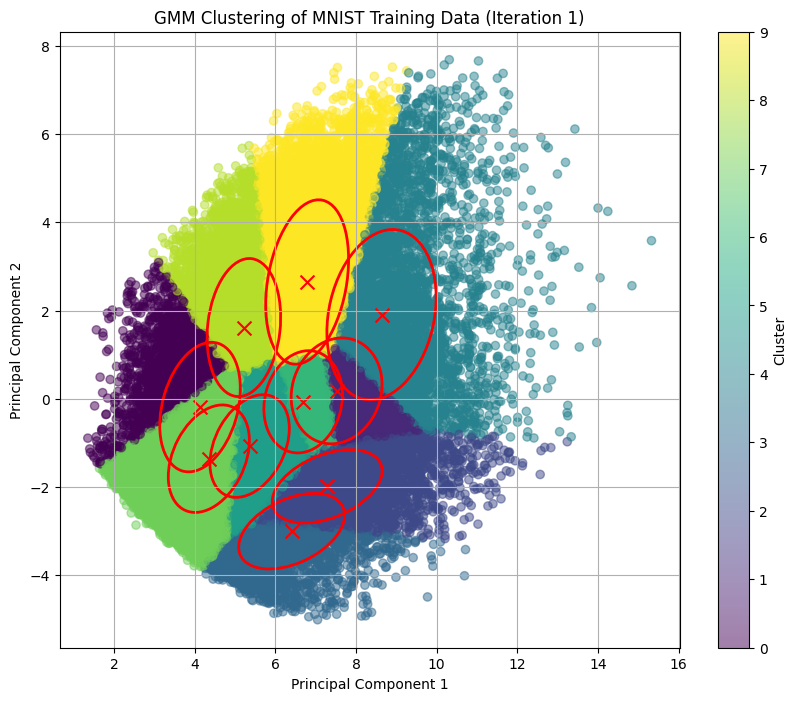

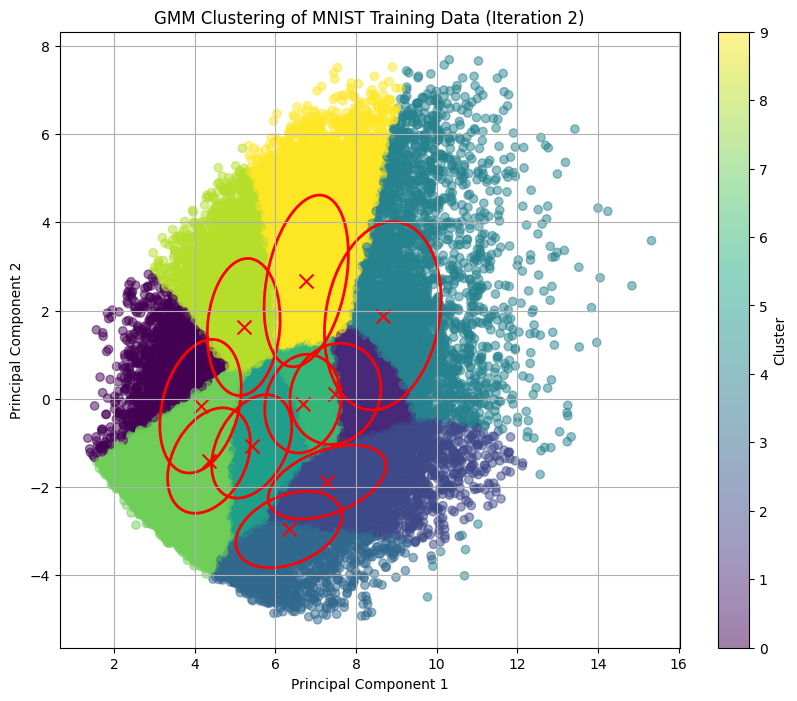

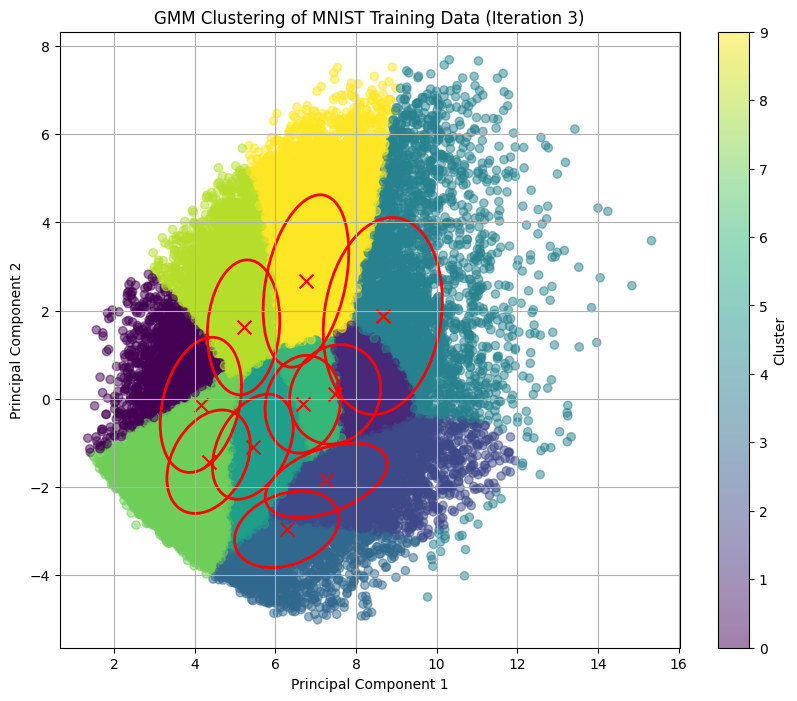

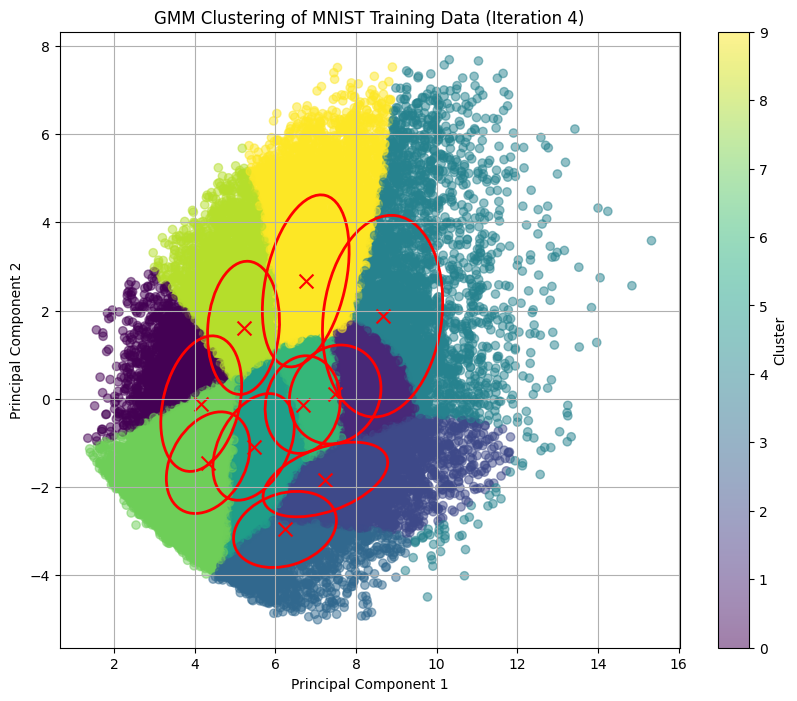

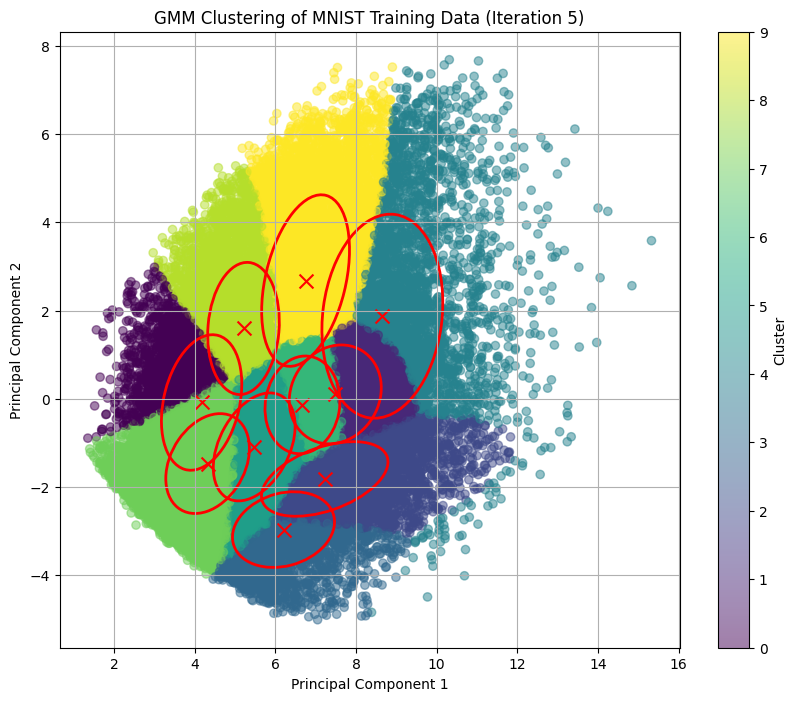

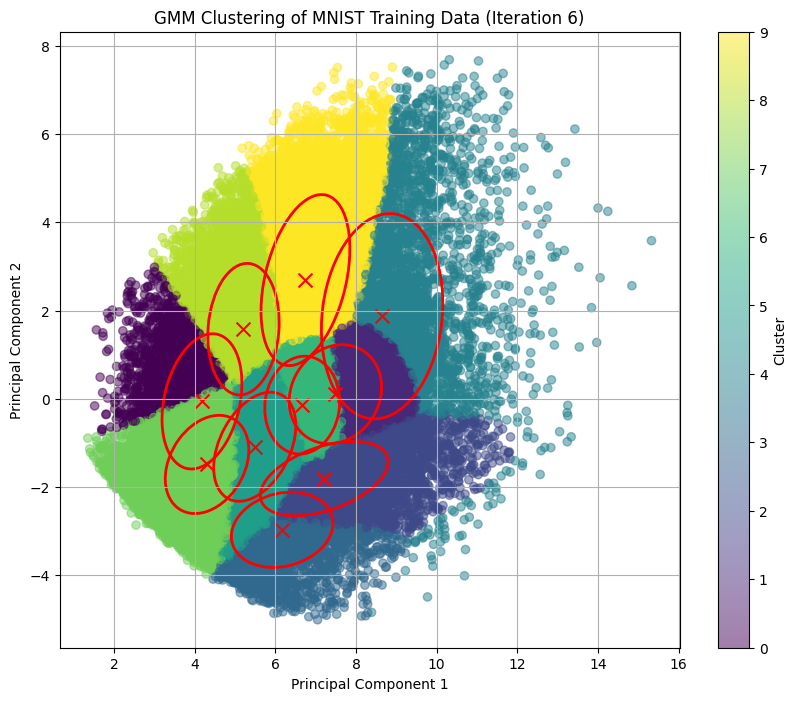

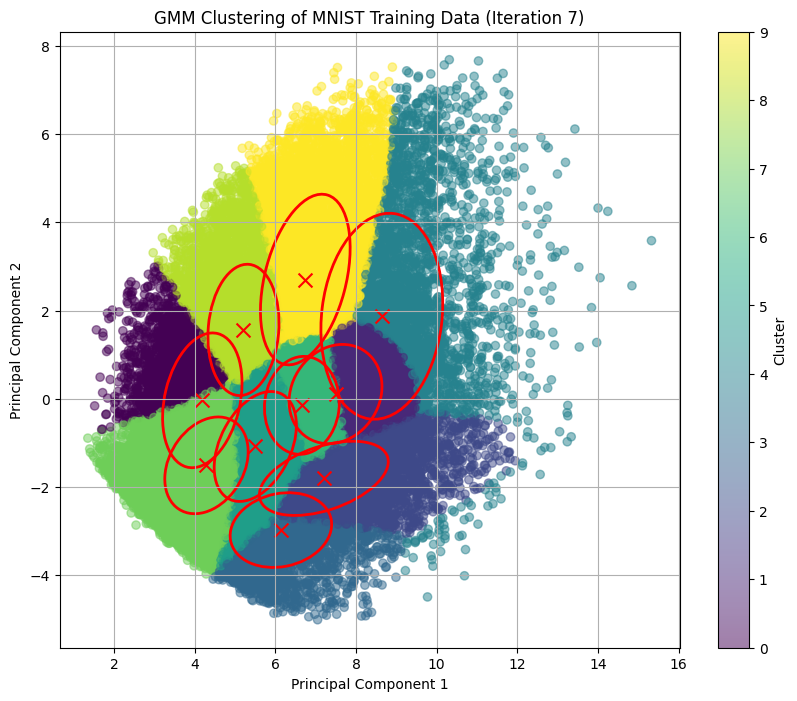

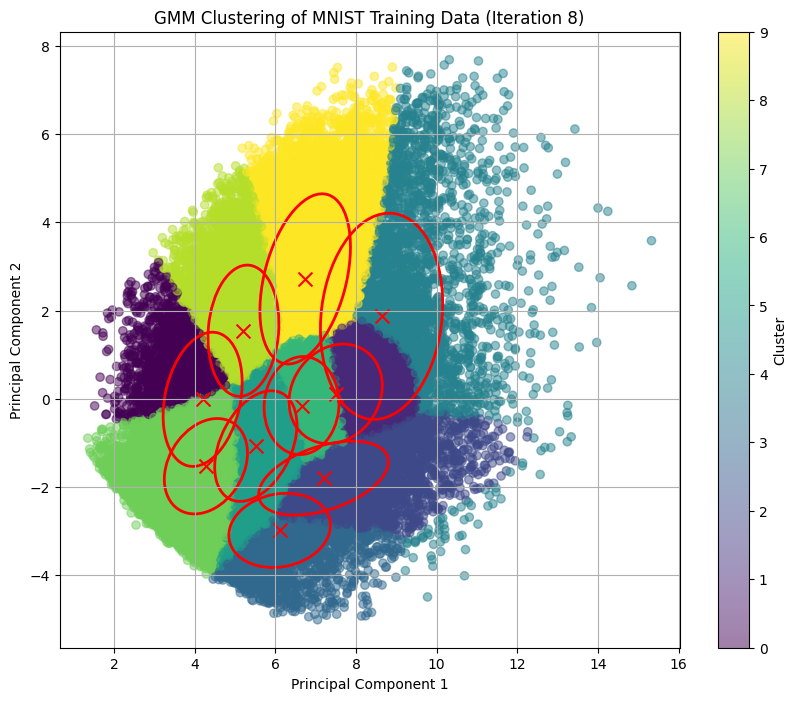

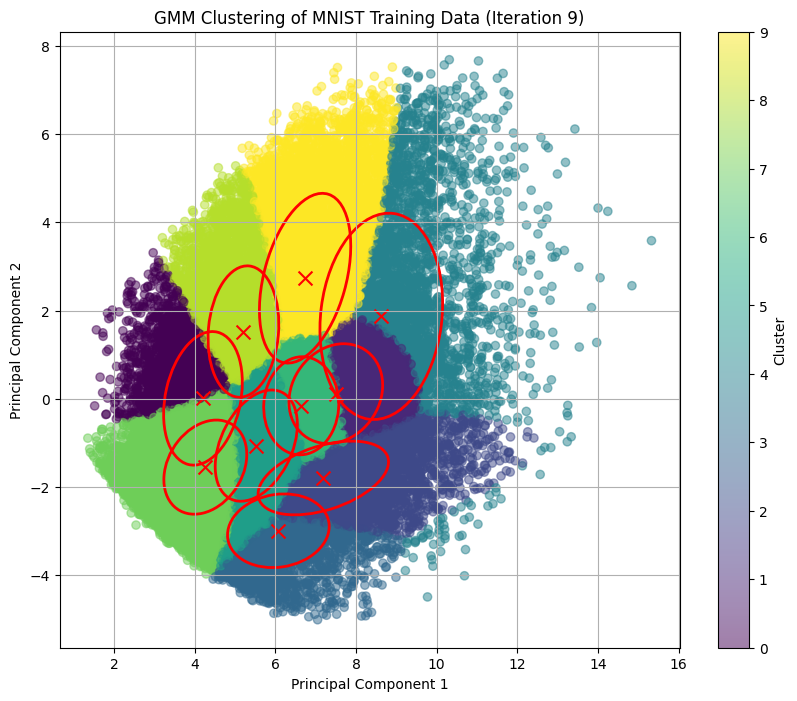

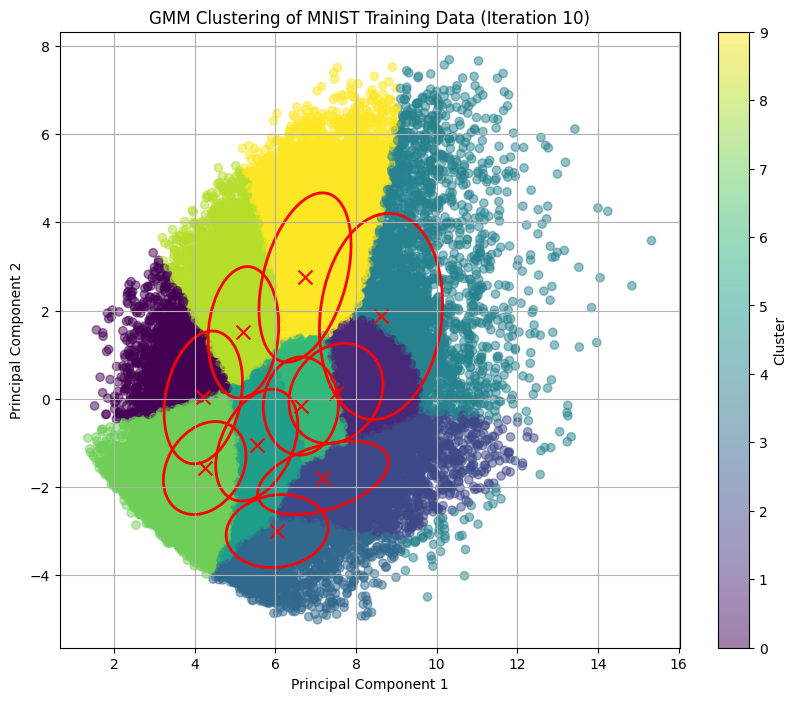

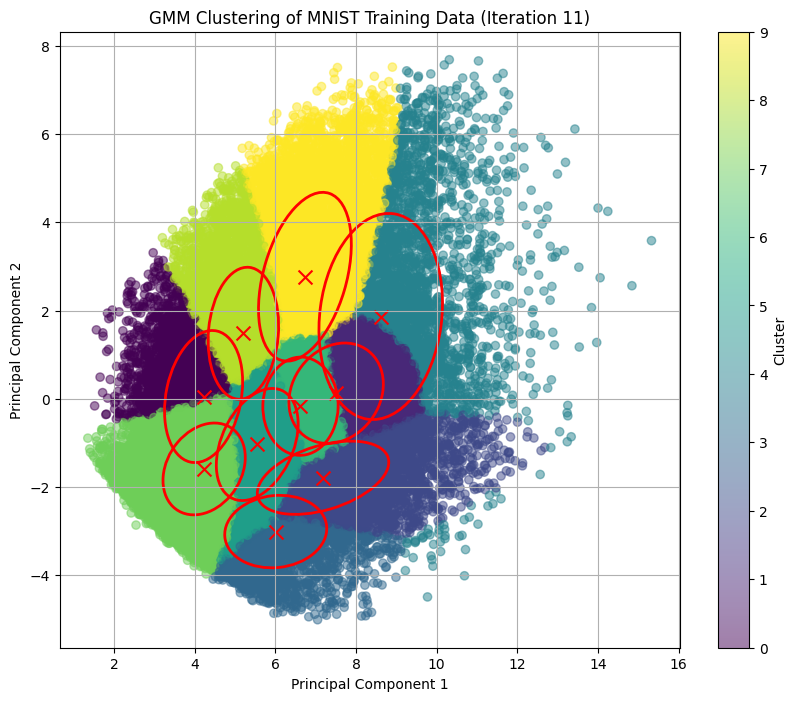

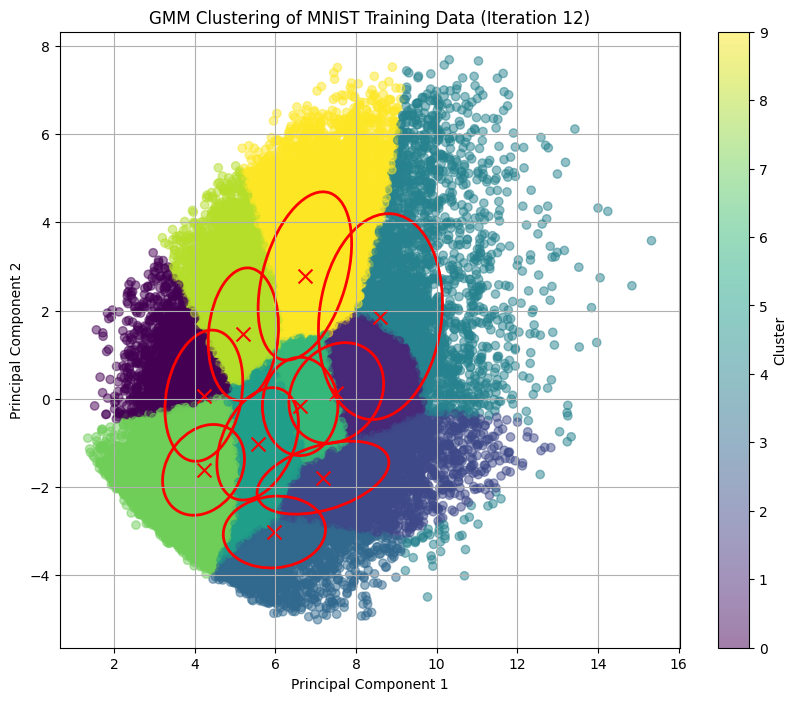

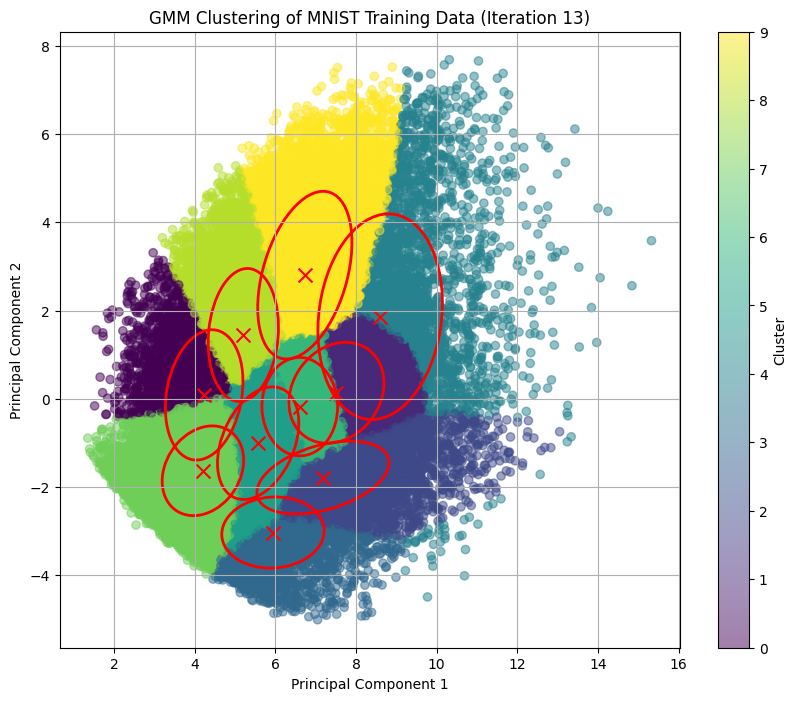

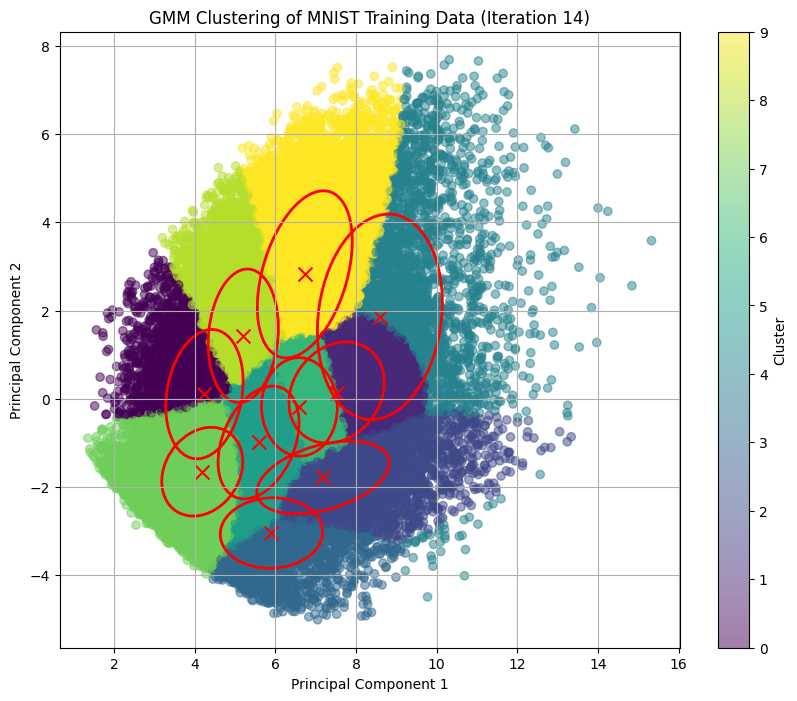

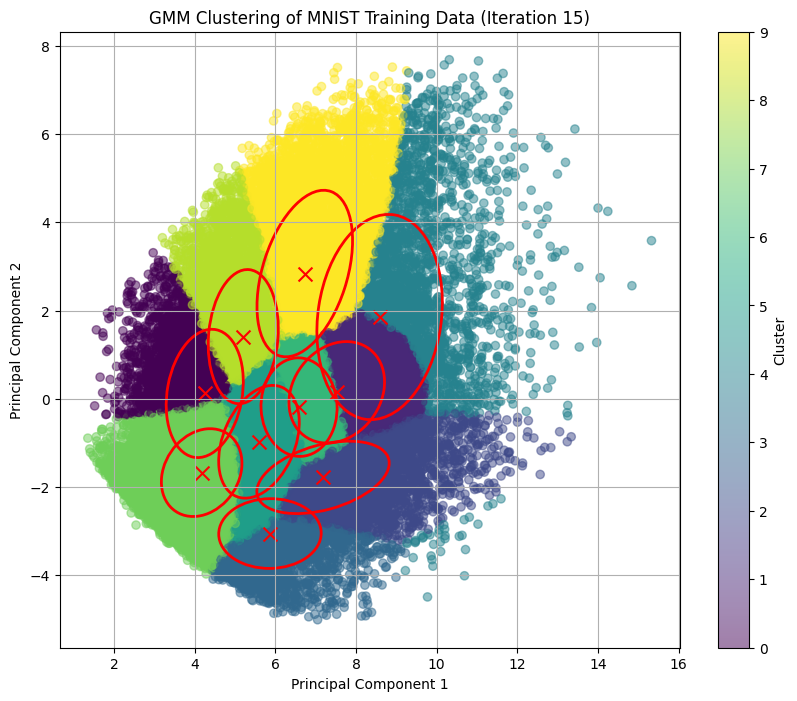

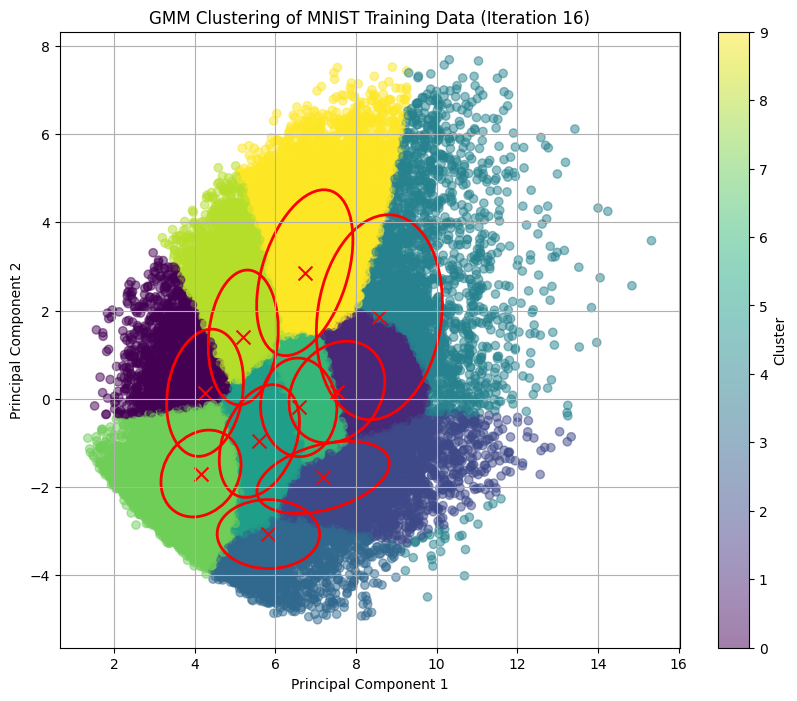

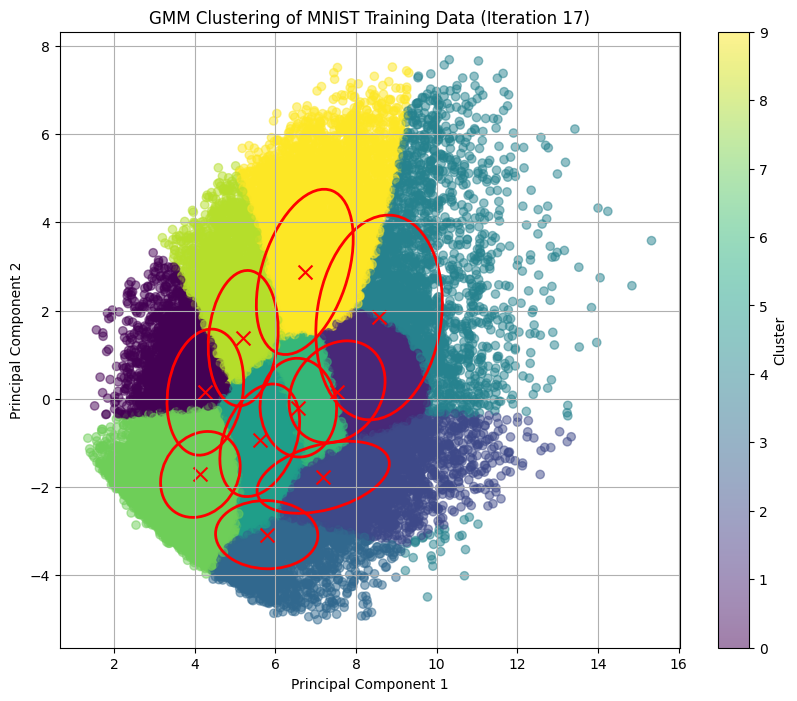

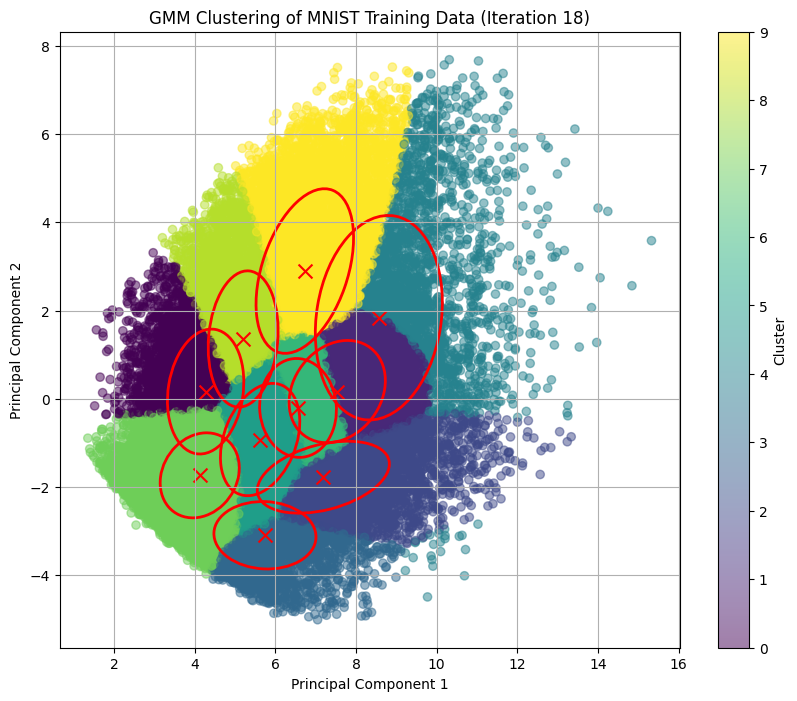

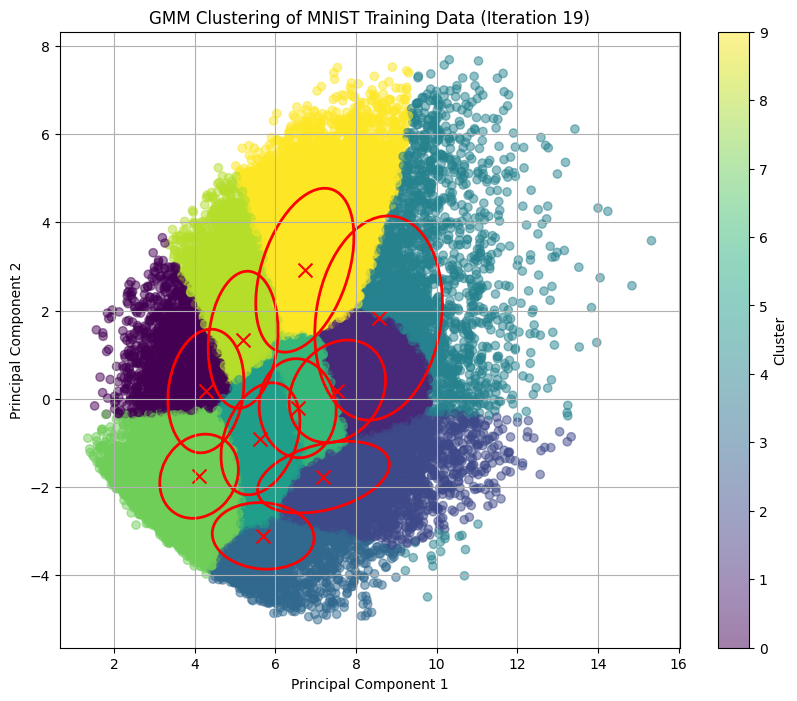

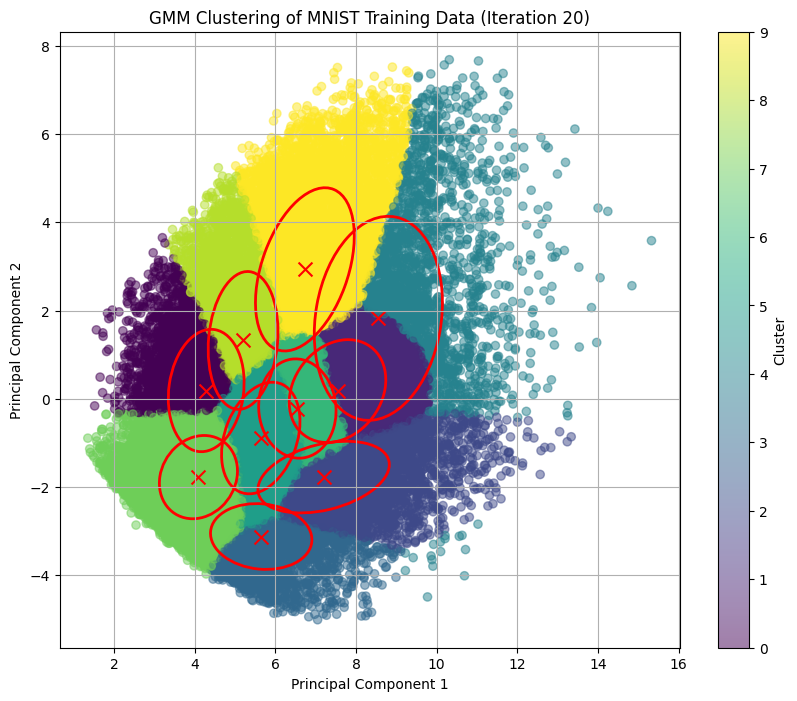

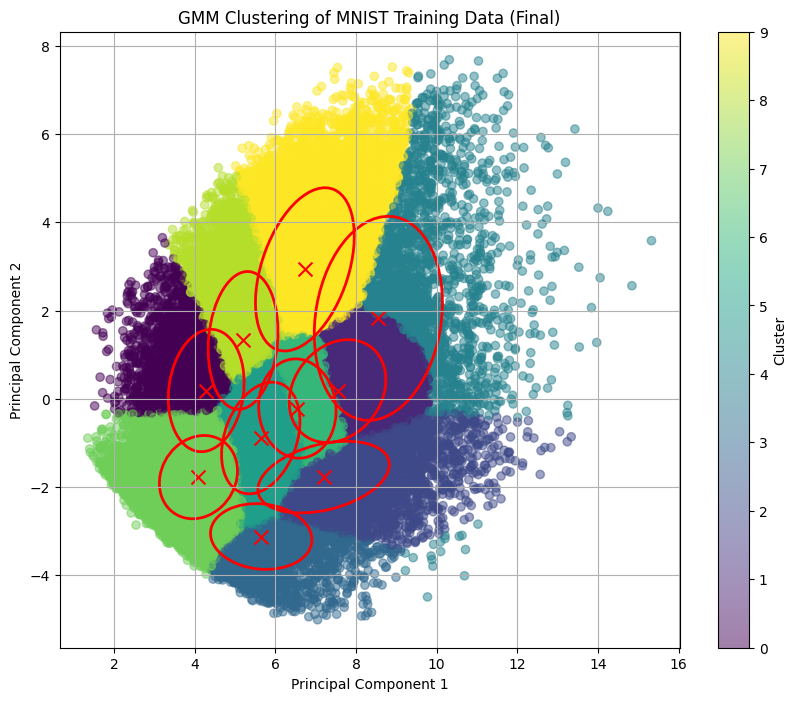

In [135]:

# Thực hiện phân cụm bằng EM với dữ liệu đã được giảm số chiều bằng PCA
responsibilities, weights, means, covariances = gmm_em(X_reduced, K, random_seed=42)

# Xác định các cụm
clusters = np.argmax(responsibilities, axis=1)

# Hiển thị kết quả phân cụm cuối cùng
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plot_ellipses(means, covariances, plt.gca())
plt.colorbar(scatter, label='Cluster')
plt.title('GMM Clustering of MNIST Training Data (Final)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [136]:
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Đánh giá chỉ số Silhouette
silhouette_avg = silhouette_score(X_reduced, clusters)
print("Average Silhouette Score:", silhouette_avg)

# Đánh giá chỉ số Adjusted Rand Index (ARI)
ari = adjusted_rand_score(y, clusters)
print("Adjusted Rand Index:", ari)

Average Silhouette Score: 0.24856194611148852
Adjusted Rand Index: 0.11137912080020619
